In [41]:
import sqlite3 
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import plotly.express as px
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
import math
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import zscore
import matplotlib.dates as mdates
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from statsmodels.tsa.api import AutoReg

## Extract

In [42]:
# Connect to the SQLite database and identify the table
cwd = os.getcwd()
database_file =  cwd + '\\sql\\d_e_summative_1'
table_name = 'climate'

try:
    # Connect to the SQLite database
    connection = sqlite3.connect(database_file)

    # Create a cursor object to interact with the database
    cursor = connection.cursor()

    # Execute a SELECT query to fetch data from the 'continuous_data' table
    execute_line = 'SELECT * FROM ' + table_name
    cursor.execute(execute_line)

    # Get the column names from the cursor description
    column_names = [description[0] for description in cursor.description]

    # Fetch all the results
    data = cursor.fetchall()

    # Create a Pandas DataFrame
    df = pd.DataFrame(data, columns=column_names)

    # Print the first 3 rows of the dataframe
    print(df.head(3))

    # Close the cursor and connection
    cursor.close()
    connection.close()

    print(f"Connected to {database_file} successfully.")

except sqlite3.Error as e:
    print(f"Error connecting to {database_file}: {e}")


         date   meantemp  humidity  wind_speed  meanpressure
0  01/01/2013  10.000000      84.5    0.000000   1015.666667
1  02/01/2013   7.400000      92.0    2.980000   1017.800000
2  03/01/2013   7.166667      87.0    4.633333   1018.666667
Connected to c:\Users\olive\OneDrive\Documents\Masters work\Data_engineering\Assignment_1\sql\d_e_summative_1 successfully.


## Cleaning

In [43]:
print('Data types before transformation:\n', df.dtypes)

# Convert the 'date_column' to datetime
df['date'] = pd.to_datetime(df['date'], format = "%d/%m/%Y")
df.set_index('date', inplace=True)

print('Data types after transformation:\n', df.dtypes)
df.head()

Data types before transformation:
 date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object
Data types after transformation:
 meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [44]:
# Data shape
print(f'The data has {df.shape[1]} columns and {df.shape[0]} rows.')

# Check for missing values
missing_val_count = df.isnull().sum().sum() # the 2nd sum provides the value for the entire dataframe (rather than each column)
print(f'There are {missing_val_count} missing values in the df dataframe, which constitutes {np.round(missing_val_count/(df.shape[1]*df.shape[0])*100, 2)}% of the dateframe.')

The data has 4 columns and 1575 rows.
There are 0 missing values in the df dataframe, which constitutes 0.0% of the dateframe.


In [45]:
sum_stat = df.describe().T.drop(['25%', '75%'], axis = 1)
sum_stat

,count,mean,std,min,50%,max
meantemp,1575.0,25.231582,7.337316,6.000000,27.166667,38.714286
humidity,1575.0,60.420115,16.956083,13.428571,62.380952,98.000000
wind_speed,1575.0,6.903642,4.508803,0.000000,6.370000,42.220000
meanpressure,1575.0,1010.589745,175.298310,-3.041667,1009.000000,7679.333333


## Exploratory Data Analysis

<Figure size 1000x800 with 0 Axes>

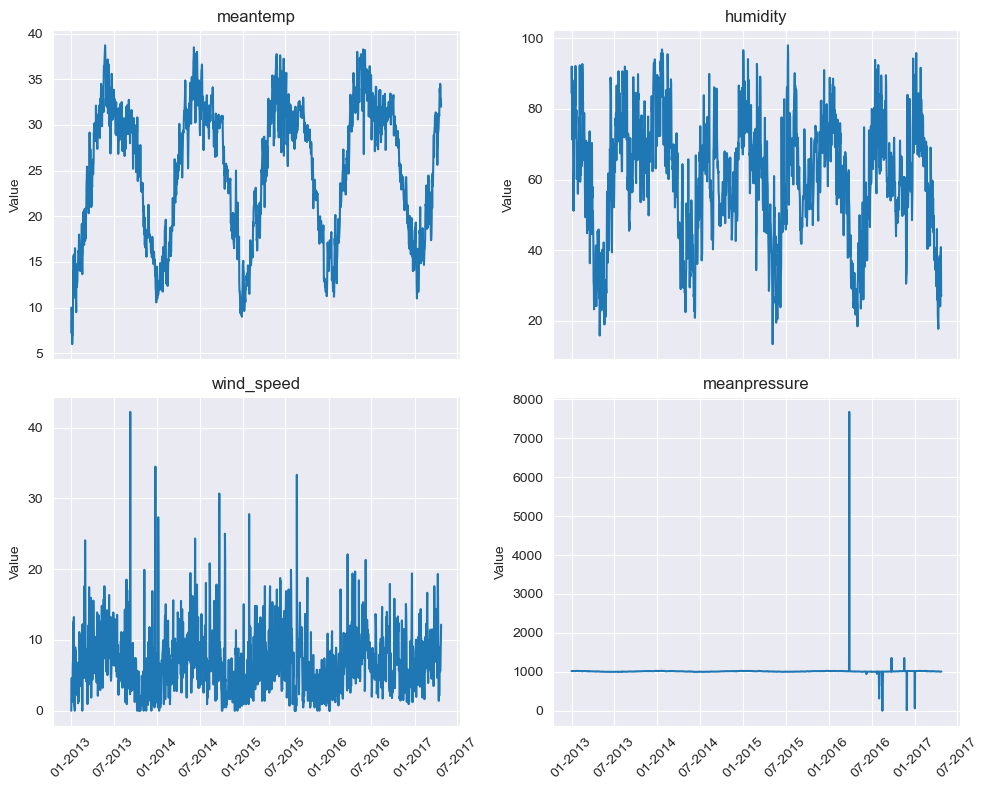

In [46]:
# Ploit cpi variable. Index 1990 = 199
# Create subplots for the numeric columns

def TimeSeriesPlot(df):

    plt.figure(figsize=(10, 8))

    # Determine the number of numeric columns
    num_columns = df.shape[1]

    # Set the style for the plots (optional)
    sns.set_style("darkgrid")

    # Create subplots for each numeric column
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex = True)

    for i, col in enumerate(df.columns):
        row, col_num = divmod(i, 2)  # Calculate the row and column number
        sns.lineplot(data=df[col], ax=axes[row, col_num])

        axes[row, col_num].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        axes[row, col_num].tick_params(axis='x', rotation=45)

        axes[row, col_num].set_title(col)
        axes[row, col_num].set_xlabel('')
        axes[row, col_num].set_ylabel('Value')

    # Show the plot
    plt.tight_layout()
    plt.savefig('timeseries.png')
    plt.show()

TimeSeriesPlot(df)

### Remove outliers

<Figure size 1000x800 with 0 Axes>

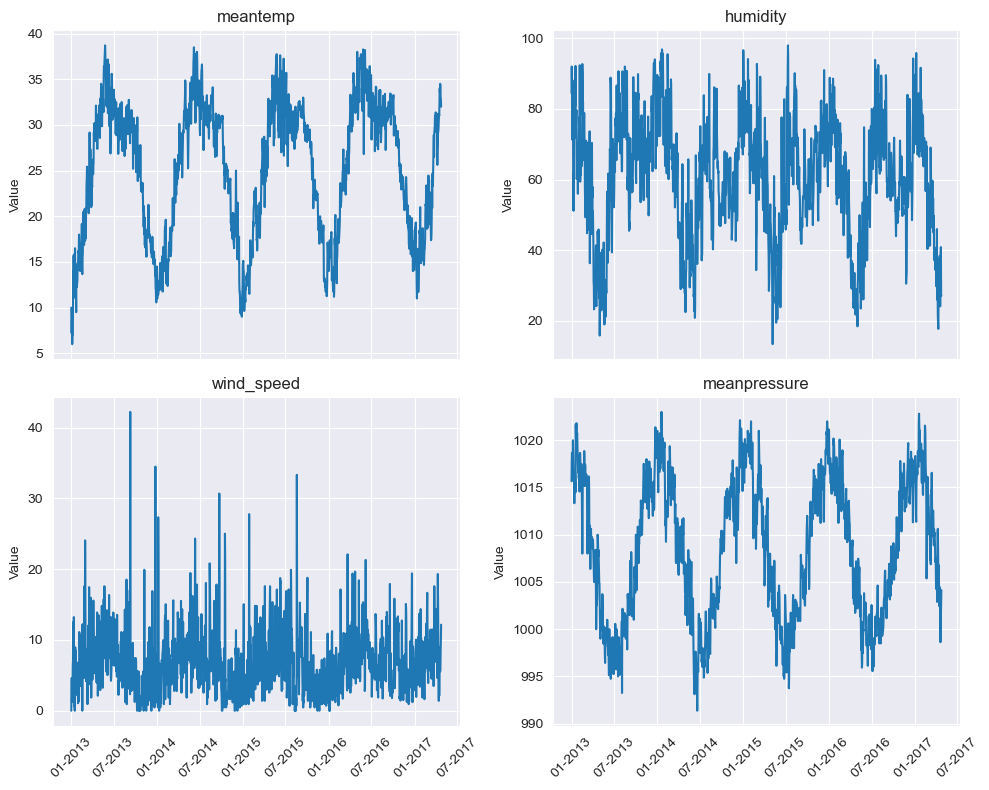

In [47]:
# Define a threshold for z-score (e.g., 3)
z_threshold = 0.3

# Calculate the z-scores for the 'meanpressure' column
z_scores_meanpressure = np.abs(zscore(df['meanpressure']))

# Remove rows where the 'meanpressure' column has a z-score greater than the threshold
df_clean = df[z_scores_meanpressure < z_threshold]

TimeSeriesPlot(df_clean)

### Principal Component Analysis

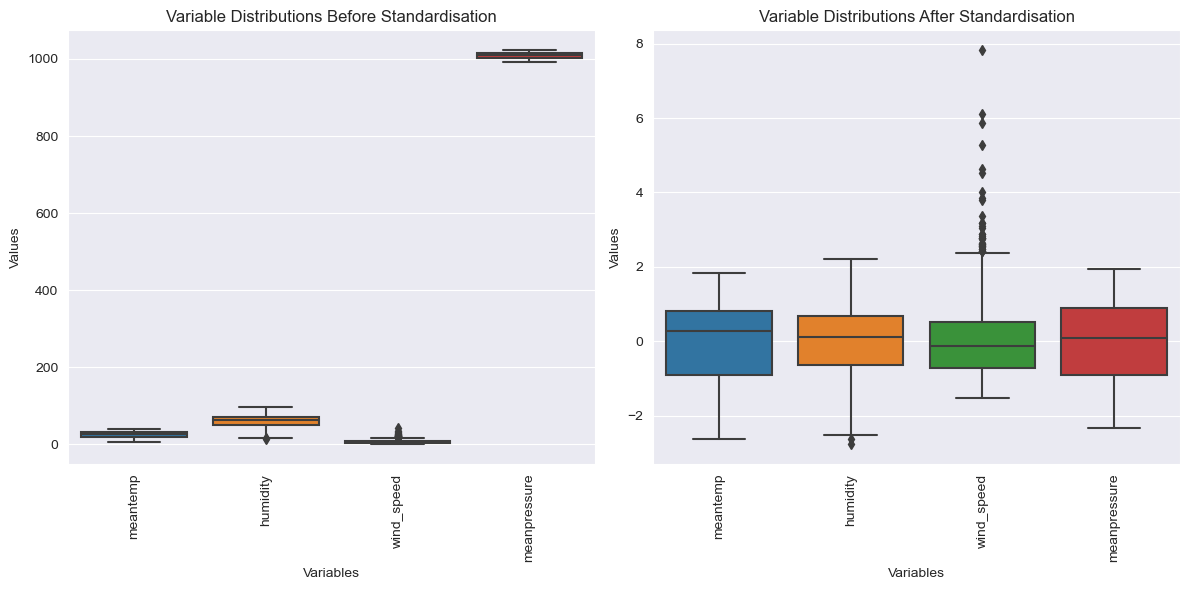

In [48]:
# Standardise the features to put them over a common unit
standard = StandardScaler()
standard.fit(df_clean)
features_standard = standard.transform(df_clean)
features_standard_df = pd.DataFrame(features_standard, columns = df_clean.columns, index=df_clean.index) 

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot variable distributions before standardization in the first subplot
sns.boxplot(data=df_clean, ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)  # Rotate x-axis labels for readability
axes[0].set_xlabel('Variables')
axes[0].set_ylabel('Values')
axes[0].set_title('Variable Distributions Before Standardisation')

# Plot variable distributions after standardization in the second subplot
sns.boxplot(data=features_standard_df, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)  # Rotate x-axis labels for readability
axes[1].set_xlabel('Variables')
axes[1].set_ylabel('Values')
axes[1].set_title('Variable Distributions After Standardisation')

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Show the combined plot
plt.savefig('boxplot.png')
plt.show()


In [49]:
# Indentify the target column
target_col = df_clean['meantemp']

# Fit PCA to 2 components
pca = PCA(n_components=2)
pca.fit(features_standard_df)

# Transform the data using the fitted model
pca_output = pca.transform(features_standard_df)

# Plot a 2D scatter plot with PCAs on each axis
fig = px.scatter(x=pca_output[:, 0], y=pca_output[:, 1], color=target_col.values, opacity=0.6)

# Format chart
fig.update_layout(
    xaxis_title=r'PCA 1',
    yaxis_title=r'PCA 2',
    width=700,
    margin=dict(r=0, b=0, l=0, t=0),
    coloraxis_colorbar=dict(title='Mean Temp')
)

fig.show()


### Testing for Stationarity

<Figure size 1000x800 with 0 Axes>

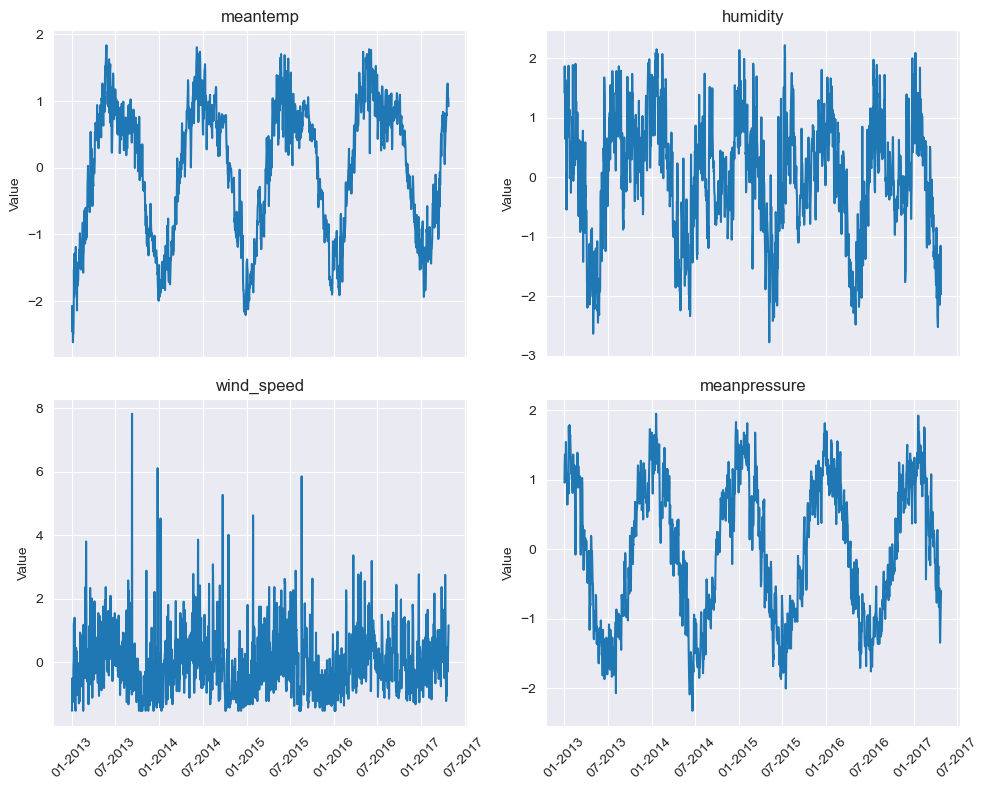

In [50]:
TimeSeriesPlot(features_standard_df)

In [51]:
# ADF Test for stationarity
#features_standard_df['meantemp_diff'] = features_standard_df['meantemp'].diff()

# Define function to test for stationarity
def TestStationary(col, alpha = 0.05):
    
    result = adfuller(col)

    print('ADF Statistic:', result[0])
    print('p-value:', result[1])  

    # Check if the ADF test rejects the null hypothesis at the significance level
    if result[1] < alpha:
        print(f'Reject the null hypothesis. {col.name} is likely stationary.')
    else:
        print(f'Fail to reject the null hypothesis. {col.name} may not be stationary.')

TestStationary(features_standard_df['meantemp'])
#TestStationary(features_standard_df['meantemp_diff'])


ADF Statistic: -2.366947411072362
p-value: 0.15128334592751574
Fail to reject the null hypothesis. meantemp may not be stationary.


## Forecasting

In [52]:
# Create train-test split with most recent observations as test observations
df_train, df_test= train_test_split(features_standard_df, test_size=0.20, shuffle= False)

# Save training target mean and std for later rescaling
target_name = 'meantemp'
target_mean = df_train[target_name].mean()
target_stdev = df_train[target_name].std()

In [53]:
print(f'The training dataset spans {min(df_train.index)} to {max(df_train.index)}\nThe testing dataset spans {min(df_test.index)} to {max(df_test.index)}')

The training dataset spans 2013-01-01 00:00:00 to 2016-06-06 00:00:00
The testing dataset spans 2016-06-07 00:00:00 to 2017-04-24 00:00:00


In [54]:
# Create a list of models with hyperparameter grids
models = [
    {
        'name': 'KNeighborsRegressor',
        'model': KNeighborsRegressor(),
        'param_grid': {
            'n_neighbors': [1, 2, 5],
            'weights': ['uniform', 'distance'],
        }
    },
    {
        'name': 'RandomForestRegressor',
        'model': RandomForestRegressor(),
        'param_grid': {
            'n_estimators': [10, 25, 100],
            'max_depth': [10, 20],
        }
    },
    {
        'name': 'NeuralNetwork',
        'model': MLPRegressor(),
        'param_grid': {
            'hidden_layer_sizes': [(100,), (50, 50), (50, 25, 10)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01],
        }
    }
]

# Create an empty DataFrame to store the performance results
performance_table = pd.DataFrame(columns=["Model", "RMSE", "R2 Score"])

# Remove forecast figures from the training and test data
X_train = df_train.drop([target_name], axis=1)
y_train = df_train[target_name]
X_test = df_test.drop([target_name], axis=1)
y_test = df_test[target_name]

# Define the number of cross-validation folds
num_folds = 10

# Create a KFold cross-validation object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)


# Create a dataframe and store test prediction values
pred_results = df_test
results_df = pd.DataFrame()

# Fit the models, perform hyperparameter tuning, and evaluate performance with cross-validation
for model_info in models:

    model_name = model_info['name']
    model = model_info['model']
    param_grid = model_info['param_grid']

    # For non-AR(1) models, continue with your existing code
    grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Add rescaled test forecast results to dataframe
    pred_results[model_name] = y_pred * target_stdev + target_mean

    # Calculate performance metrics on the test set
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Create a DataFrame for the current model's results
    model_results = pd.DataFrame({"Model": [model_name], "RMSE": [rmse]})

    # Concatenate the results with the performance_table
    results_df = pd.concat([results_df, model_results], ignore_index=True)

results_df

df_out = pred_results[['meantemp', 'KNeighborsRegressor', 'RandomForestRegressor', 'NeuralNetwork']]

# Create a line plot 
fig = px.line(df_out, labels=dict(created_at="Date", value="Degrees Centigrade"))

# Add a vertical line at the minimum index of the test data for reference
fig.add_vline(x=min(df_test.index), line_width=4, line_dash="dash")

# Update the layout 
fig.update_layout(
    legend=dict(orientation='h', y=1.02, title_text="")  )

# Display the finalized plot
fig.show()

# Plor bar chart
fig = px.bar(results_df, x="Model", y="RMSE",
             barmode='group')
fig.show()

## Load

In [55]:
# Connect to SQLite database
conn = sqlite3.connect(database_file)

# Write DataFrame to SQLite table
df_out.to_sql('predictions', conn, index=False, if_exists='replace')

# Close the database connection
conn.close()